<a href="https://colab.research.google.com/github/rogerwzeng/e17/blob/main/DMDG_PSET6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 6 (65 pts)

In this problem set, you'll explore topics in machine learning for computer vision.

You will be designing and training neural networks. Training these neural networks can take some time so you might run into some issues with your Colab session deloading. Some suggestions to address this:
- Use GPU runtime to speed up training. To activate GPU runtime, go to the top menu bar > Runtime > Change runtime type > Select GPU. This will make a significant difference (can be 10-50x faster with GPUs)
- Make sure to run the data loading and prep cell each time if and when the session deloads, otherwise you won't have any data to work with
- Run each neural network separately; each network can be trained independently of the other (as long as the data prep is loaded). Thus, if one section is done, you don't need to re-run it again to move to the next session in the case your session deloaded.
- An alternative solution is to download the notebook and use your local machine (which has no time constraints). However, this is a more advanced option and may require some setup and configuration



In [2]:
### DO NOT CHANGE ###
# importing the libraries (do not remove or add libraries)
from typing import List, Set, Dict, Tuple, Optional
from PIL import Image
import os
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

## Context & Data Preparation (0 pts)

You're working as a Machine Learning lead for a computer vision based drone start-up. The start-up has been contracted by the US National Park Services to monitor and track plant species in the US National Parks.

As the Machine Learning lead, you need to prepare vision-based machine learning models that can accurately identify different plant species. As an initial proof-of-concept, you'll be building models for classifying different flowers using a dataset provided by your team. This will be invaluable for the start-up to automatically analyze and label drone footage of the park.

In this problem set, you'll experiement with the following approaches:
- Feed Forward Neural Network
- Convolutional Neural Network
- Transfer Learning


Run the below **Data Overview** cell to load / prep in your data, print out some summary information, and visualize some examples from your dataset. **<font color='red'>Note: you must run the below cell, otherwise the later parts of the notebook won't run.**</font>

228813984/228813984 [==============================] - 11s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


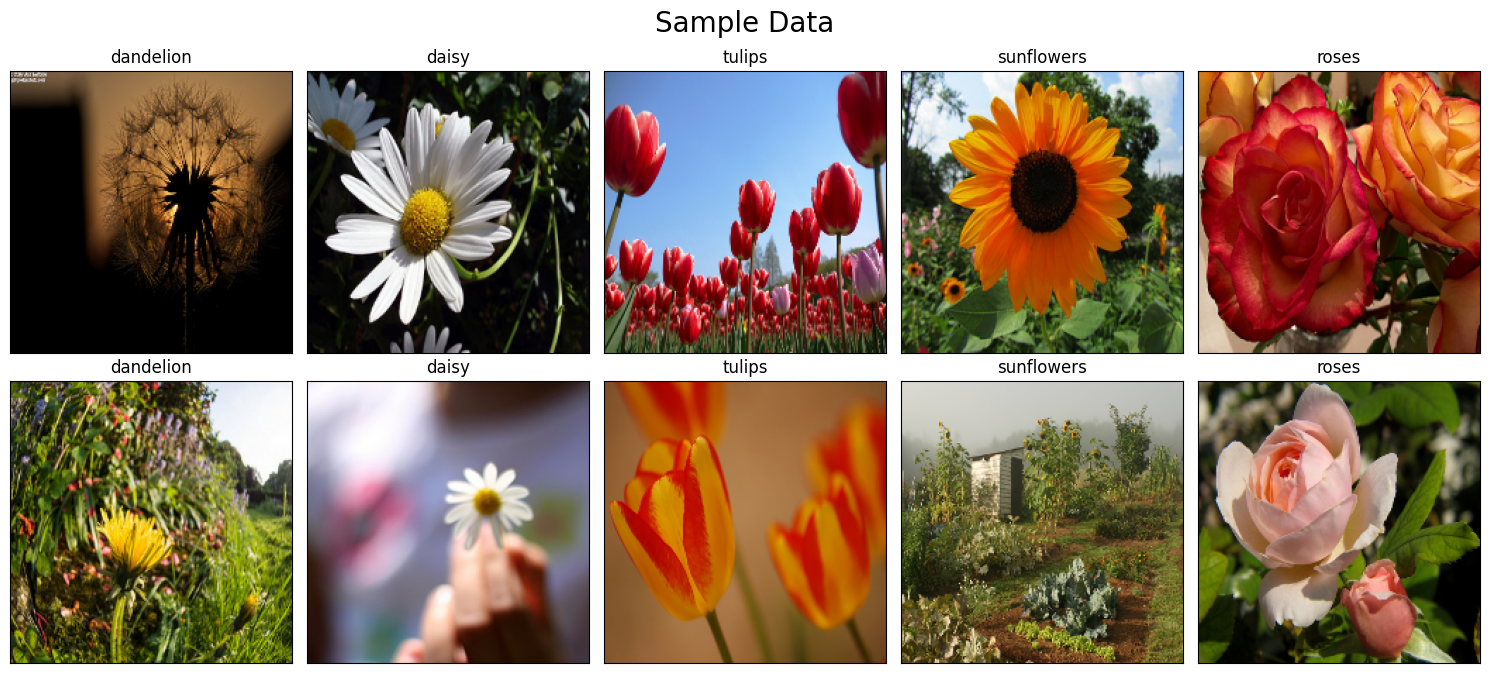

In [3]:
### DO NOT CHANGE ###
#@title Data Overview
if __name__ == "__main__":
    tf.get_logger().setLevel('ERROR')
    tf.random.set_seed(17)

    # download the data
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
    data_dir = pathlib.Path(archive).with_suffix('')

    # display some images
    IMAGE_DIM = 200
    dandelion = list(data_dir.glob('dandelion/*'))
    daisy = list(data_dir.glob('daisy/*'))
    tulips = list(data_dir.glob('tulips/*'))
    sunflowers = list(data_dir.glob('sunflowers/*'))
    roses = list(data_dir.glob('roses/*'))
    sample_images = [
        [
            (dandelion[0], "dandelion"),
            (daisy[0], "daisy"),
            (tulips[0], "tulips"),
            (sunflowers[0], "sunflowers"),
            (roses[2], "roses")
        ],
        [
            (dandelion[1], "dandelion"),
            (daisy[1], "daisy"),
            (tulips[1], "tulips"),
            (sunflowers[1], "sunflowers"),
            (roses[3], "roses")
        ],
    ]
    fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 7))
    fig.suptitle(f"Sample Data", fontsize=20)
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            img = Image.open(str(sample_images[r][c][0]))
            img = tf.image.resize(img, (IMAGE_DIM, IMAGE_DIM)) / 255
            ax[r, c].set_xticks([])
            ax[r, c].set_yticks([])
            ax[r, c].imshow(img)
            ax[r, c].set_title(f"{sample_images[r][c][1]}")

    plt.tight_layout()

    # create training and testing size
    BATCH_SIZE = 32
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=17,
        image_size=(IMAGE_DIM, IMAGE_DIM),
        batch_size=BATCH_SIZE)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=17,
        image_size=(IMAGE_DIM, IMAGE_DIM),
        batch_size=BATCH_SIZE)

    # labels to id
    id2label = {i: l for i, l in enumerate(train_ds.class_names)}
    label2id = {l: i for i, l in enumerate(train_ds.class_names)}

## Feed Forward Neural Networks (15 pts)

The first approach you will try is a Feed Forward Neural Network. This will serve as a baseline model for your experimentation.

**Note**: Although in practice, you'd design your own networks and iterate on them, for this problem set, **please design the network as specified**.

Build the `ffnn_model` (10 pts). The architecture for the Neural Network for this section is:
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency) - this is already done for you
- A flatten layer with an input shape that corresponds to the dimensions of our image, which is `(200, 200, 3)`
- One hidden / dense layer with 256 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- A second hidden / dense layer with 128 nodes and activation `relu`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [5]:
# define our Feed Forward Neural Network Model
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)  #No activation function per instruction
])

After defining the model, we can compile and train it. Run the below the cell.

Epoch 1/15
92/92 [==============================] - 2s 13ms/step - loss: 1.6009 - accuracy: 0.2432 - val_loss: 1.5955 - val_accuracy: 0.2534
Epoch 2/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6014 - accuracy: 0.2428 - val_loss: 1.5959 - val_accuracy: 0.2534
Epoch 3/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6003 - accuracy: 0.2435 - val_loss: 1.5956 - val_accuracy: 0.2534
Epoch 4/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6000 - accuracy: 0.2435 - val_loss: 1.5956 - val_accuracy: 0.2534
Epoch 5/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6014 - accuracy: 0.2428 - val_loss: 1.5955 - val_accuracy: 0.2534
Epoch 6/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6013 - accuracy: 0.2428 - val_loss: 1.5958 - val_accuracy: 0.2534
Epoch 7/15
92/92 [==============================] - 1s 12ms/step - loss: 1.6002 - accuracy: 0.2435 - val_loss: 1.5958 - val_accuracy: 0.2534
Epoch 8/15
92

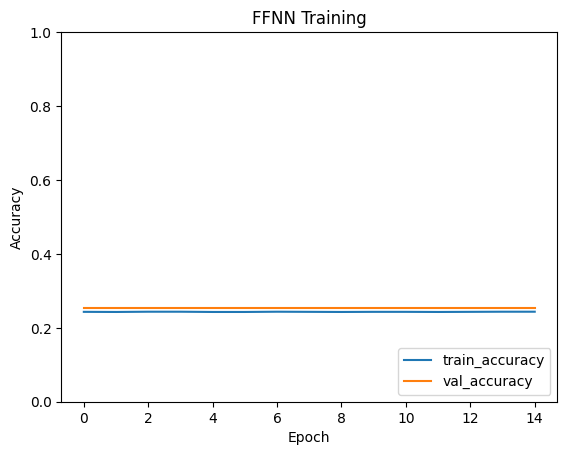

In [9]:
### DO NOT CHANGE ###
#@title Run to Compile & Train the FFNN Model
if __name__ == "__main__":
    tf.random.set_seed(17)

    # compile model
    ffnn_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    # train model
    EPOCH = 15
    ffnn_history = ffnn_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)
    ffnn_model.summary()

    # visualize the training history and get the performance
    plt.plot(ffnn_history.history['accuracy'], label='train_accuracy')
    plt.plot(ffnn_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("FFNN Training")
    plt.legend(loc='lower right')

In [ ]:
#@title Evaluate the Model

#@markdown What was the highest validation accuracy achieved by the Feed Forward Neural Network (as a number between 0 to 1)? (5 pts)

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
ffnn_highest_val_acc = "0.2534" #@param {type:"string"}

Feed Forward Neural Network generally struggle with image data due to the spatial elements and patterns in the data. Let's experiment with convolutional neural networks which generally perform better with images.

## Convolutional Neural Networks (15 pts)

The second approach you will try is a Convolutional Neural Network. Ideally, there should be a significant improvement in accuracy.

Build the `cnn_model` (10 pts). The architecture for the Neural Network for this section is:
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency)
- An initial 2D convolutional layer of 32 filters with input shape corresponding to our image dimensions, kernel size $5 \times 5$, padding `same`, and activation `relu`
- One 2D max pooling layer with a pool size of (2, 2)
- A second 2D convolutional layer of 64 filters with kernel size $3 \times 3$, padding `same`, and activation `relu`
- A second 2D max pooling layer with pool size of (2, 2)
- A third 2D convolutional layer of 32 filters with kernel size $3 \times 3$, padding `same`, and activation `relu`
- A third 2D max pooling layer with pool size of (2, 2)
- A flattening layer
- One hidden / dense layer with 512 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- One hidden / dense layer with 128 nodes and activation `relu`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling), [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [`MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [ ]:
# define our Convolutional Neural Network Model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)  # No activation function for the output layer
])

Epoch 1/15
92/92 [==============================] - 3s 17ms/step - loss: 0.0931 - accuracy: 0.9796 - val_loss: 9.5299 - val_accuracy: 0.3774
Epoch 2/15
92/92 [==============================] - 1s 15ms/step - loss: 0.0979 - accuracy: 0.9799 - val_loss: 10.1238 - val_accuracy: 0.3760
Epoch 3/15
92/92 [==============================] - 2s 15ms/step - loss: 0.0999 - accuracy: 0.9809 - val_loss: 10.1302 - val_accuracy: 0.4046
Epoch 4/15
92/92 [==============================] - 1s 15ms/step - loss: 0.0514 - accuracy: 0.9850 - val_loss: 10.7997 - val_accuracy: 0.4264
Epoch 5/15
92/92 [==============================] - 1s 15ms/step - loss: 0.0385 - accuracy: 0.9905 - val_loss: 9.7178 - val_accuracy: 0.4264
Epoch 6/15
92/92 [==============================] - 1s 15ms/step - loss: 0.0737 - accuracy: 0.9864 - val_loss: 11.5221 - val_accuracy: 0.4223
Epoch 7/15
92/92 [==============================] - 1s 15ms/step - loss: 0.1617 - accuracy: 0.9683 - val_loss: 8.6042 - val_accuracy: 0.4101
Epoch 8/1

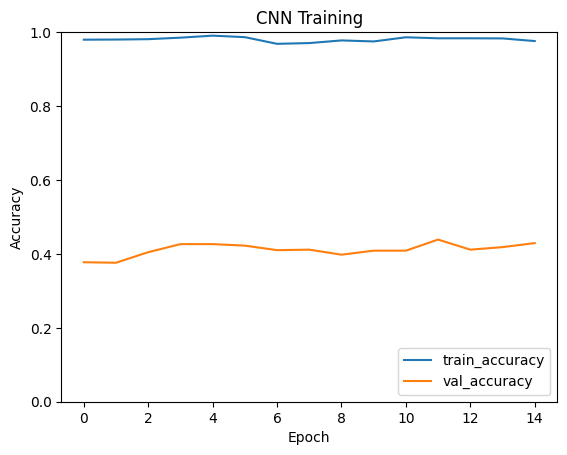

In [ ]:
### DO NOT CHANGE ###
#@title Run to Compile & Train the CNN Model
if __name__ == "__main__":
    tf.random.set_seed(17)

    # compile model
    cnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    # train model
    EPOCH = 15
    cnn_history = cnn_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("CNN Training")
    plt.legend(loc='lower right')

In [ ]:
#@title Evaluate the Model

#@markdown What was the highest validation accuracy achieved by the Convolutional Neural Network (as a number between 0 to 1)? (5 pts)

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
cnn_highest_val_acc = "0.4387" #@param {type:"string"}

Both models we've considered so far have been trained from scratch. In general, it can be advantageous to start with a model that has already been pre-trained on some other dataset. The pre-trained model can leverage knowledge from its previous training for its new task - hence this practice is called transfer learning. Let's experiment with pre-trained models and transfer learning.

## Pre-Trained Neural Networks & Transfer Learning (15 pts)

The final approach you will try is a Pre-Trained Neural Network with some fine-tuning. Ideally, there should be a significant improvement in accuracy.

Build the `transfer_model` (10 pts). The architecture for the Neural Network for this section is:
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency)
- A pre-trained base model feature extractor
- A global average pooling 2D layer
- One dense layer of 128 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling), [`GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [ ]:
# get the pre-trained model and freeze the weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# define our Pre-Trained Neural Network Model
transfer_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,  # Add the pre-trained base model
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5)  # Output dense layer for 5 classes

])

Epoch 1/15
92/92 [==============================] - 5s 28ms/step - loss: 0.1677 - accuracy: 0.9782 - val_loss: 0.6042 - val_accuracy: 0.8651
Epoch 2/15
92/92 [==============================] - 2s 18ms/step - loss: 0.1633 - accuracy: 0.9758 - val_loss: 0.5726 - val_accuracy: 0.8815
Epoch 3/15
92/92 [==============================] - 2s 18ms/step - loss: 0.1683 - accuracy: 0.9741 - val_loss: 0.5738 - val_accuracy: 0.8719
Epoch 4/15
92/92 [==============================] - 2s 18ms/step - loss: 0.1740 - accuracy: 0.9734 - val_loss: 0.5338 - val_accuracy: 0.8828
Epoch 5/15
92/92 [==============================] - 2s 18ms/step - loss: 0.1526 - accuracy: 0.9840 - val_loss: 0.5343 - val_accuracy: 0.8910
Epoch 6/15
92/92 [==============================] - 2s 19ms/step - loss: 0.1692 - accuracy: 0.9768 - val_loss: 0.5322 - val_accuracy: 0.8842
Epoch 7/15
92/92 [==============================] - 2s 18ms/step - loss: 0.1579 - accuracy: 0.9819 - val_loss: 0.5688 - val_accuracy: 0.8842
Epoch 8/15
92

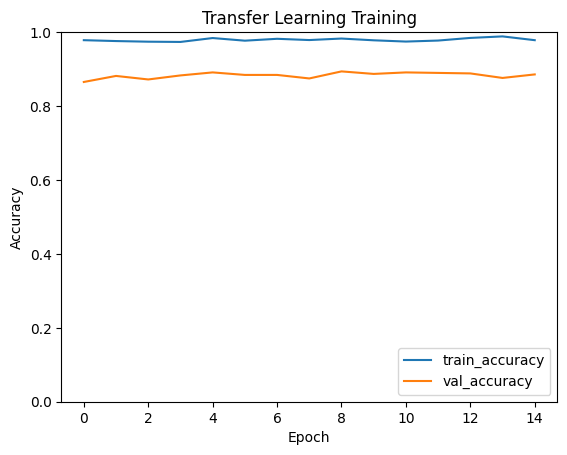

In [ ]:
### DO NOT CHANGE ###
#@title Run to Compile & Finetune the Pre-Trained Model
if __name__ == "__main__":
    tf.random.set_seed(17)

    # compile model
    transfer_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    # train model
    EPOCH = 15
    transfer_history = transfer_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(transfer_history.history['accuracy'], label='train_accuracy')
    plt.plot(transfer_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("Transfer Learning Training")
    plt.legend(loc='lower right')

In [ ]:
#@title Evaluate the Model

#@markdown What was the highest validation accuracy achieved by the Fine-Tuned Pre-Trained Neural Network (as a number between 0 to 1)? (5 pts)

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
transfer_highest_val_acc = "0.8924" #@param {type:"string"}

## Conclusion (15 pts)

Congrats! You've built three distinct deep learning, neural network models. Answer the below concept check questions and choose the most correct option.

In [ ]:
#@title Concept Checks

#@markdown Which model was the best performing (in terms of validation accuracy)? (3 pts)
best_model = "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)" #@param ["", "Feed Forward Neural Network", "Convolutional Neural Network", "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)"]

#@markdown Which model demonstrated the most overfitting (i.e., learns the training data very well but fails to generalize on the validation data)? (3 pts)
most_overfitted_model = "Convolutional Neural Network" #@param ["", "Feed Forward Neural Network", "Convolutional Neural Network", "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)"]

#@markdown In general, what should you expect for the accuracy as you increase the number of epochs? (3 pts)
increase_num_of_epochs = "The training accuracy should increase but the validation accuracy may not necessarily always increase" #@param ["", "The training accuracy should increase but the validation accuracy may not necessarily always increase", "The validation accuracy should increase but the training accuracy may not necessarily always increase", "Both the training and validation accuracy should always keep increasing", "There is no relationship between the number of epochs and training / validation accuracy"]

#@markdown In general, what should you expect for the accuracy as you increase the complexity (number of components and layers) of your model? (3 pts)
increase_complexity = "The validation accuracy will improve to a point but the training accuracy should keep improving" #@param ["", "The training and validation accuracy will increase as the model is able to handle more complex patterns", "The training accuracy will increase as the model will underfit and the validation accuracy will go down as the model fails to generalize", "The training accuracy will improve to a point but the validation accuracy should keep improving", "The validation accuracy will improve to a point but the training accuracy should keep improving"]

#@markdown In general, which of the following situations would the model you built here perform the worst in? (3 pts)
worst_situation = "A drone fleet system to monitor and track farm animals" #@param ["", "An app for gardeners to identify different flower species in their garden", "A drone fleet system to monitor and track farm animals", "A research project on invasive flower species in New England forests", "Classifying different vegetation and trees along coastal areas"]

You may have noticed that there is still room for improvement on the validation accuracy - the next step as the Machine Learning lead would be to experiment and try different models to acheive a high validation accuracy. In general, a high validation accuracy translates to better performance in application.

If you are interested in improving the validation accuracy of your model, explore the extra credit section.

## EXTRA CREDIT: Custom Neural Network (10-20 pts)

**Note**: This section is optional extra credit for all credit status (undergraduates and graduate students). This section is intended for students looking for more depth or advanced material. This section may require additional self-study to complete. Since this is extra credit, assistance from Gradescope will be limited. Furthermore, there will be limited support from course staff, office hours, and Ed discussion.

So far, you've been building neural networks prescriptively based on the specifications. For extra credit, design your own custom neural network. You are free to leverage any pre-trained models, implement custom architectures, and set  hyperparameters. You are also free to use either TensorFlow or PyTorch (either will suffice) and any pre-trained model(s).

If your model achieves **at least 93% accuracy on the validation set, you'll get 10 extra credit points**. If your model achieves **at least 96% accuracy on the validation set, you'll get 20 extra credit points**.

In terms of work and submission, **please do this in a separate notebook altogether**. Once you've designed a neural network that acheives the minimum validation accuracy, **please email your notebook submission to the course staff at harvard.dgmd17@gmail.com**.

The reason for a separate notebook is because this section is very open-ended (i.e., many ways of doing it) and course staff will grade it separately.

In terms of the data, the dataset for this problem set is an open source dataset, called [`tf_flowers`](https://www.tensorflow.org/datasets/catalog/tf_flowers). You can either download / access it in which ever method you find most convenient from online or you can copy the code in the Context & Data Preparation section which downloads it for you.

In terms of grading, the course staff will review and execute your notebook with the validation set - please make check that the code runs with no errors (so explicitly disconnect your runtime and re-run everything to make sure it works). Additionally, label or clearly document which section is the final model versus your experiments / prototypes.

In [ ]:
# Extra credit problem

IMAGE_DIM = 200

# Base model with ResNet152
base_model = tf.keras.applications.ResNet152V2(input_shape=(IMAGE_DIM, IMAGE_DIM, 3),
                       include_top=False,
                       weights='imagenet')
base_model.trainable = False

# define our Pre-Trained Neural Network Model
transfer_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,  # Add the pre-trained base model
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5)  # Output dense layer for 5 classes

])

Epoch 1/15
92/92 [==============================] - 17s 88ms/step - loss: 0.0794 - accuracy: 0.9816 - val_loss: 1.0161 - val_accuracy: 0.8488
Epoch 2/15
92/92 [==============================] - 5s 59ms/step - loss: 0.0471 - accuracy: 0.9871 - val_loss: 0.9784 - val_accuracy: 0.8610
Epoch 3/15
92/92 [==============================] - 5s 58ms/step - loss: 0.0412 - accuracy: 0.9891 - val_loss: 0.6737 - val_accuracy: 0.8856
Epoch 4/15
92/92 [==============================] - 5s 58ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.7784 - val_accuracy: 0.8896
Epoch 5/15
92/92 [==============================] - 5s 59ms/step - loss: 0.0065 - accuracy: 0.9963 - val_loss: 0.9742 - val_accuracy: 0.8638
Epoch 6/15
92/92 [==============================] - 5s 58ms/step - loss: 0.0266 - accuracy: 0.9939 - val_loss: 0.9627 - val_accuracy: 0.8501
Epoch 7/15
92/92 [==============================] - 5s 58ms/step - loss: 0.0296 - accuracy: 0.9898 - val_loss: 0.8285 - val_accuracy: 0.8774
Epoch 8/15
9

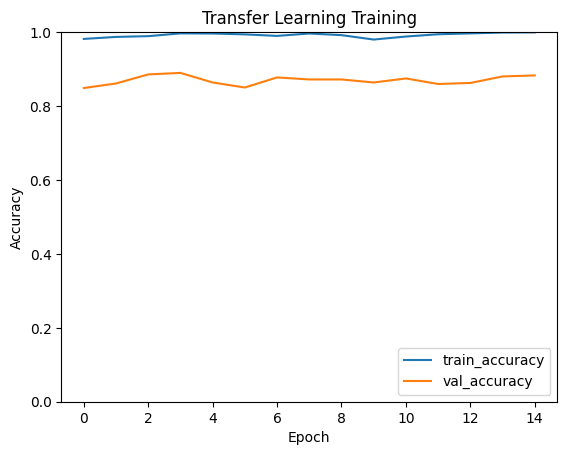

In [ ]:
#@title Run to Compile & Finetune the Pre-Trained Model
if __name__ == "__main__":
    tf.random.set_seed(17)

    # compile model
    transfer_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    # train model
    EPOCH = 15
    transfer_history = transfer_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(transfer_history.history['accuracy'], label='train_accuracy')
    plt.plot(transfer_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("Transfer Learning Training")
    plt.legend(loc='lower right')

## Problem Set Survey (5 pts)

Please fill out the survey questions (the first five are each worth 1 point; the last one is optional).


1.   `TIME` (1 pt): approximately how many hours did you spend on the problem set? Please use decimals to express partial hours (e.g., a value of `2.5` means two and half hours).
2.   `DIFFICULTY` (1 pt): on a scale of 1-10, how difficult was this problem set with 1 being very easy and 10 being very hard?
3.   `FAVORITE_PART` (1 pt): What was your favorite topic / learning from the unit (i.e., between the last pset and this pset)? This should contain at least 10 words.
4.   `WENT_WELL` (1 pt): What went well? Describe what went well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
5.   `CHALLENGING` (1 pt): What was challenging? Describe what was challenging or didn't go well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
6.   `COMMENTARY` (0 pt): If there is anything else you'd like to share with course staff, please add it here. If not, no need to change / edit the default string.


In [ ]:
#@title Problem Set Survey Questions
TIME = "2.5" #@param {type:"string"}

DIFFICULTY = "5" #@param ["", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

FAVORITE_PART = "This is my first time coding a tansfer learning model and it's quite interesting." #@param {type:"string"}

WENT_WELL = "Using Keras to build neural networks are straightforward and intuitive." #@param {type:"string"}

CHALLENGING = "Keras library masked much of the complexity of the underlying neural network, making it harder to tweak and fine tune." #@param {type:"string"}

COMMENTARY = "" #@param {type:"string"}

**<font color='red'>To submit, please download as a Python (.py) file and submit on Gradescope (navigate to File > Download > Download .py). Please use the correct file name and comment out any test / extraneous code to avoid any compile and parser issues </font>**